In [ ]:
# SPDX-FileCopyrightText: Copyright (c) 2023 NVIDIA CORPORATION & AFFILIATES. All rights reserved.
# SPDX-License-Identifier: LicenseRef-NvidiaProprietary

# NVIDIA CORPORATION, its affiliates and licensors retain all intellectual
# property and proprietary rights in and to this material, related
# documentation and any modifications thereto. Any use, reproduction,
# disclosure or distribution of this material and related documentation
# without an express license agreement from NVIDIA CORPORATION or
# its affiliates is strictly prohibited.

# Local Co-pilot: CodeLlama 34B Go Brrr on A SINGLE 24 GB GPU!

CodeLlama 34B Instruct, a conversational model is designed for general code synthesis and understanding. It is capable of code completion and instruct following.

In this notebook, we will build a local Co-pilot using CodeLlama 34B Instruct which runs on a single GPU with 24 GB memory.
The original CodeLlama 34B has 34B parameters and requires ~ 64 GB of GPU memory. It is not possible to fit the entire model in our 24 GB GPU and run fast inference &#x1F623;.

## TensorRT-LLM To The Rescue !!

Therefore, we will use **TensorRT/TensorRT-LLM Quantization Toolkit** to quantize the model weights to INT4 (W4A16) and build a TensorRT-LLM (TRTLLM) engine.

## Setup

Please follow the installation steps [here](https://github.com/NVIDIA/TensorRT-LLM?tab=readme-ov-file#installation) to create TensorRT-LLM docker image.

TensorRT-LLM quantization toolkit, named `nvidia-ammo` automatically gets installed with TensorRT-LLM.

In this tutorial, we will be using the `nvidia-ammo 0.9`, the latest version of ammo which got released just last week. The 'nvidia-ammo' installed by default in the TensorRT-LLM image is an older version. So lets install the latest one:

In [ ]:
%pip install nvidia-ammo~=0.9 --extra-index-url https://pypi.nvidia.com

### Additional System Requirements

This demo will be done in two stages.

* **Stage 1: Pytorch Model Quantization & Checkpoint Export**: This stage is run on a machine with atleast 4 x 24GB GPUs

* **Stage 2: TRTLLM Engine Build & Inference**: This stage is run on a machine with single 24 GB GPU


## Stage 0: Importing Packages &  Defining Arguments (Common for both Stage 1 & Stage 2)

First, let's install the remaining required packages to run this notebook.

In [ ]:
%pip install transformers accelerate datasets

Lets import all the required python packages first.

In [ ]:
# Import needed packages
import time
import torch
import ammo.torch.quantization as atq
import ammo.torch.opt as ato

from pathlib import Path
from datasets import load_dataset
from torch.utils.data import DataLoader

from transformers import AutoTokenizer, AutoModelForCausalLM

from ammo.torch.export import export_tensorrt_llm_checkpoint
from ammo.deploy.llm import build_tensorrt_llm
from ammo.deploy.llm import LLM

Lets define the input arguments.

In [4]:
model_path = "CodeLlama/CodeLlama-34b-Instruct-hf"

# TRTLLM engine configurations
model_type = "llama"
export_path = "CodeLlama-34b-Instruct-int4-awq"
tensor_parallel_world_size = 1
max_input_len = 2048
max_output_len = 512
max_batch_size = 1

engine_dir = Path(export_path, f"{model_type}_input{max_input_len}_output{max_output_len}_batch{max_batch_size}_tp{tensor_parallel_world_size}")

Let's initialize the tokenizer.

In [5]:
tokenizer = AutoTokenizer.from_pretrained(model_path, padding_side="left", truncation_side="left",use_fast=False)
tokenizer.pad_token = tokenizer.eos_token

We are using a chat version of Codellama. The chat model input needs to be user queries empedded into the the following prompt: ` "<s>[INST] {query} [/INST]" `.
Lets write a function for this.

In [6]:
def get_prompt(query):
    return f"<s>[INST] {query.strip()} [/INST]"

query = "Write a python function to check if the input string is a palindrome or not."
get_prompt(query)

'<s>[INST] Write a python function to check if the input string is a palindrome or not. [/INST]'

## Stage 1: Pytorch Model Quantization & Checkpoint Export

Inference on the original pytorch fp16 model requires about 4 X 24 GPUs. Hence we will run this stage on a machine with atleast 4 X 24GB GPUs.

Now, lets instantiate the original un-quantized pytorch CodeLlama model from Huggingface.

In [7]:
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto", torch_dtype=torch.float16)

Loading checkpoint shards: 100%|██████████| 7/7 [00:18<00:00,  2.60s/it]


Lets check the model size and how much memory it occupies.

In [8]:
def get_model_size(model):
    size = sum(p.numel()*p.element_size() for p in model.parameters())
    size += sum(b.numel()*b.element_size() for b in model.buffers())
    return size
print(f"Model size: {get_model_size(model)/2**30:.2f} GB")

Model size: 63.23 GB


Lets now implement a text generator function on top of the Huggingface model.

In [9]:
def generate_pytorch(
    model, tokenizer, prompt, num_tokens_to_generate=512, do_sample=False
    ):
        inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
        outputs = model.generate(
            **inputs,
            max_length=num_tokens_to_generate,
            do_sample=do_sample,
        )
        return tokenizer.decode(outputs[0], skip_special_tokens=True).split('[/INST]')[-1]

We should test the model's generation capabilities now.

In [10]:
query = "Write a python function to check if the input string is a palindrome or not."
response = generate_pytorch(model, tokenizer, get_prompt(query))
print(response)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


  Here is a Python function that checks if a given string is a palindrome or not:
```
def is_palindrome(s):
    return s == s[::-1]
```
This function takes a string `s` as input and checks if it is equal to its reverse using the slicing notation `s[::-1]`. If the string is a palindrome, the function returns `True`, otherwise it returns `False`.

Here's an example of how you can use this function:
```
>>> is_palindrome("racecar")
True
>>> is_palindrome("not a palindrome")
False
```
This function works by taking advantage of the fact that a palindrome is a string that reads the same backward as it does forward. By comparing the original string to its reverse, we can determine if it is a palindrome or not.


Lets quantize this model now. First, lets create a dataloader for providing calibration data to the model.

In [11]:
def get_calib_dataloader(tokenizer=None, batch_size=1, calib_size=512, block_size=512, device=None
):
    print("Loading calibration dataset")
    dataset = load_dataset("cnn_dailymail", name="3.0.0", split="train")
    
    #dataset = load_dataset("bigcode/the-stack", data_dir="data/python", split="val")
    
    dataset = dataset["article"][:calib_size]

    batch_encoded = tokenizer.batch_encode_plus(
        dataset, return_tensors="pt", padding=True, truncation=True, max_length=block_size
    )
    if device:
        batch_encoded = batch_encoded.to(device)
    batch_encoded = batch_encoded["input_ids"]

    calib_dataloader = DataLoader(batch_encoded, batch_size=batch_size, shuffle=False)

    return calib_dataloader

calib_dataloader = get_calib_dataloader(
                tokenizer=tokenizer,
                batch_size=32,
                calib_size=32,
                device=torch.device("cuda"),
            )

Loading calibration dataset


Generating test split: 100%|██████████| 11490/11490 [00:00<00:00, 78085.34 examples/s]


We have everything we need for quantizing and calibrating the model now. AMMO's `atq.quantize()` API is used for performing quantization and calibration. 

The model to be quantized, the quantization configuration and a `forward_loop` which forwards the calibration data through the model are the inputs to `atq.quantize()`.

This API inserts simulated quantizer/dequantizer (Q/DQ) nodes to the model, calls `forward_loop` and collect the needed statistics for quantization calibration.

In [12]:
def forward_loop(model):
        print("Calibrating model...")
        for i, data in enumerate(calib_dataloader):
            print(f"Batch: {i+1}/{len(calib_dataloader)}")
            model(data)

# Calibration loop
quantized_model = atq.quantize(model, atq.INT4_AWQ_CFG, forward_loop)

# To save the model for future use:
# ato.save(quantized_model, "quantized_int4_model.pt")

# To restore the model from saved checkpoint:
# Give the original, unquantized model as input to the restore function
# quantized_model = ato.restore(model, "quantized_int4_model.pt")

Replaced 1011 modules to quantized modules
Caching activation statistics for awq_lite...
Calibrating model...
Batch: 1/1
Searching awq_lite parameters...
Calibrating model...
Batch: 1/1
Loading extension ammo_cuda_ext...


/usr/local/lib/python3.10/dist-packages/ammo/torch/quantization/nn/modules/tensor_quantizer.py:168: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("_pre_quant_scale", torch.tensor(value))


Loading extension ammo_cuda_ext_fp8...


/usr/local/lib/python3.10/dist-packages/ammo/torch/quantization/nn/modules/tensor_quantizer.py:170: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=self._pre_quant_scale.device)
/usr/local/lib/python3.10/dist-packages/ammo/torch/quantization/nn/modules/tensor_quantizer.py:168: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("_pre_quant_scale", torch.tensor(value))


Lets print the quantized model summary and make sure that the quantizer nodes are placed correctly in the model.

In [14]:
atq.print_quant_summary(quantized_model)

model.layers.0.self_attn.q_proj.input_quantizer                                  TensorQuantizer(disabled)
model.layers.0.self_attn.q_proj.output_quantizer                                 TensorQuantizer(disabled)
model.layers.0.self_attn.q_proj.weight_quantizer                                 TensorQuantizer(4 bit fake block_sizes={-1: 128}, amax=[0.0028, 7.4648](524288) calibrator=MaxCalibrator quant)
model.layers.0.self_attn.k_proj.input_quantizer                                  TensorQuantizer(disabled)
model.layers.0.self_attn.k_proj.output_quantizer                                 TensorQuantizer(disabled)
model.layers.0.self_attn.k_proj.weight_quantizer                                 TensorQuantizer(4 bit fake block_sizes={-1: 128}, amax=[0.0092, 2.9199](65536) calibrator=MaxCalibrator quant)
model.layers.0.self_attn.v_proj.input_quantizer                                  TensorQuantizer(disabled)
model.layers.0.self_attn.v_proj.output_quantizer                                

The quantized model is a fully valid pytorch model. You can evaluate the quantized model same as you evaluate a regular Pytorch model. Lets check the text generated by the model and make sure everything works fine.

In [15]:
query = "Write a python function to check if the input string is a palindrome or not."
response = generate_pytorch(quantized_model, tokenizer, get_prompt(query))
print(response)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


  Here is a Python function that checks if a given string is a palindrome or not:
```
def is_palindrome(s):
    return s == s[::-1]
```
Explanation:

* The function takes a string `s` as input.
* It checks if the string is equal to its reverse using the slicing notation `s[::-1]`. This notation returns the string in reverse order.
* If the string is equal to its reverse, it means that it is a palindrome, and the function returns `True`.
* If the string is not equal to its reverse, it means that it is not a palindrome, and the function returns `False`.

Here's an example of how to use the function:
```
print(is_palindrome("racecar")) # Output: True
print(is_palindrome("not a palindrome")) # Output: False
```
Note that this function assumes that the input string is not empty. If the input string is empty, the function will return `True` because an empty string is considered a palindrome. If you want to handle empty strings differently, you can modify the function accordingly.


Lets export the model checkpoint. This checkpoint will be used by TRTLLM to build the engine.
Please see [prepare-the-tensorrt-llm-checkpoint](https://github.com/NVIDIA/TensorRT-LLM/blob/main/docs/source/new_workflow.md#prepare-the-tensorrt-llm-checkpoint) to learn more about the checkpoint format.

In [16]:
with torch.inference_mode():
    start_time = time.time()
    export_tensorrt_llm_checkpoint(
        quantized_model,
        model_type,
        torch.float16,
        export_dir=export_path,
        inference_tensor_parallel=tensor_parallel_world_size, # you may modify this number to enable multi GPU TP
    )
    end_time = time.time()
    print(
        f"Quantized model exported to : {export_path}. Total time used {end_time - start_time:.3f} s"
    )

torch.distributed not initialized, assuming single world_size.
torch.distributed not initialized, assuming single world_size.
torch.distributed not initialized, assuming single world_size.
torch.distributed not initialized, assuming single world_size.
torch.distributed not initialized, assuming single world_size.
torch.distributed not initialized, assuming single world_size.
torch.distributed not initialized, assuming single world_size.
torch.distributed not initialized, assuming single world_size.
current rank: 0, tp rank: 0, pp rank: 0
torch.distributed not initialized, assuming single world_size.
Quantized model exported to : CodeLlama-34b-Instruct-int4-awq. Total time used 149.681 s


Model checkpoint has been exported. **Stage 1: Pytorch Model Quantization & Checkpoint Export** is complete. Lets stop execution on the multi-GPU machine now.

## Stage 2: TRTLLM Engine Build & Inference

We are ready to build TRTLLM engine now. The engine is built on the same machine it needs to be served which is a machine with single 24 GB GPU for this demo. So this stage is ran from the machine with single 24GB GPU.

Lets build the TRTLLM engine now.

In [7]:
config_path = Path(export_path, f"config.json")

build_tensorrt_llm(
        pretrained_config=config_path,
        engine_dir=engine_dir,
        max_input_len=max_input_len,
        max_output_len=max_output_len,
        max_batch_size=max_batch_size
    )

[03/17/2024-15:41:28] [TRT] [W] Unused Input: position_ids
[03/17/2024-15:41:29] [TRT] [W] Detected layernorm nodes in FP16.
[03/17/2024-15:41:29] [TRT] [W] Running layernorm after self-attention in FP16 may cause overflow. Exporting the model to the latest available ONNX opset (later than opset 17) to use the INormalizationLayer, or forcing layernorm layers to run in FP32 precision can help with preserving accuracy.
[03/17/2024-15:41:29] [TRT] [W] [RemoveDeadLayers] Input Tensor position_ids is unused or used only at compile-time, but is not being removed.
[03/17/2024-15:41:29] [TRT] [W] TensorRT was linked against cuDNN 8.9.6 but loaded cuDNN 8.9.4
[03/17/2024-15:42:16] [TRT] [W] TensorRT was linked against cuDNN 8.9.6 but loaded cuDNN 8.9.4


Thats it! TRTLLM engine have been built. Lets load the engine and run inference using TRTLLM python runtime.

In [8]:
free_memory_before = torch.cuda.mem_get_info()
llm = LLM(engine_dir, tokenizer=tokenizer)

Loading Model: [1/1]	Load TensorRT-LLM engine


[03/17/2024-15:44:57] [TRT] [W] TensorRT was linked against cuDNN 8.9.6 but loaded cuDNN 8.9.4
[03/17/2024-15:44:58] [TRT] [W] TensorRT was linked against cuDNN 8.9.6 but loaded cuDNN 8.9.4
[03/17/2024-15:44:58] [TRT] [W] TensorRT was linked against cuDNN 8.9.6 but loaded cuDNN 8.9.4
[03/17/2024-15:44:58] [TRT-LLM] [W] The paged KV cache in Python runtime is experimental. For performance and correctness, please, use C++ runtime.


Time: 92.764s
Loading model done.
Total latency: 92.764s


In [9]:
query = "Write a python function to check if the input string is a palindrome or not."
outputs = llm.generate_text([get_prompt(query)], max_output_len)
print(outputs[0])

/usr/local/lib/python3.10/dist-packages/torch/nested/__init__.py:165: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /opt/pytorch/pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  return _nested.nested_tensor(


 Here is a Python function that checks if a given string is a palindrome or not:
```
def is_palindrome(s):
    return s == s[::-1]
```
Explanation:

* The function takes a string `s` as input.
* It checks if the string is equal to its reverse using the slicing notation `s[::-1]`. This notation returns the string in reverse order.
* If the string is equal to its reverse, it means that it is a palindrome, and the function returns `True`.
* If the string is not equal to its reverse, it means that it is not a palindrome, and the function returns `False`.

Here's an example of how you can use this function:
```
print(is_palindrome("racecar")) # Output: True
print(is_palindrome("not a palindrome")) # Output: False
```
Note that this function is case-sensitive, so "Racecar" and "racecar" are considered different strings. If you want to make the function case-insensitive, you can convert the input string to lowercase before comparing it to its reverse.


Let me ask our Co-pilot to help me on something.

In [10]:
human_eval_scores = {"Codellama 7b FP16": 33.64, "Codellama 34b W4A16": 43.60}
query= "Here is a dictionary where the keys are Codellama model names " \
    f"and the values are the HumanEval scores of the model: {human_eval_scores}. " \
    "Write a Python method to plot a bar chart of the HumanEval scores. " \
    "Give the first bar the color 'darkseagreen' and the second bar the color 'lawngreen'." \
    "Turn on the y-axis grid lines and set the title of the plot to 'HumanEval Scores of Codellama models'. " \
    "The y-axis range should be (minimum HumanEval score - 5, maximum HumanEval score + 5). " \
    "The x-axis label should be 'Model Name' and the y-axis label should be 'HumanEval Score'."
outputs = llm.generate_text([get_prompt(query)], max_output_len)
print(outputs[0])

 Here is a possible implementation of the method you described:
```
import matplotlib.pyplot as plt

def plot_human_eval_scores(scores):
    # Create a bar chart of the HumanEval scores
    plt.bar(scores.keys(), scores.values(), color=['darkseagreen', 'lawngreen'])
    plt.grid(True, axis='y')
    plt.title('HumanEval Scores of Codellama models')
    plt.ylim(min(scores.values()) - 5, max(scores.values()) + 5)
    plt.xlabel('Model Name')
    plt.ylabel('HumanEval Score')
    plt.show()
```
You can call this method by passing in the dictionary of HumanEval scores as an argument, like this:
```
scores = {'Codellama 7b FP16': 33.64, 'Codellama 34b W4A16': 43.6}
plot_human_eval_scores(scores)
```
This will create a bar chart with two bars, one for each model, and display it using Matplotlib. The first bar will be colored 'darkseagreen' and the second bar will be colored 'lawngreen'. The y-axis grid lines will be turned on, and the title of the plot will be 'HumanEval Scores of Codellama 

Thank you Local Co-Pilot for the code!! &#x1F600; Productivity is off to the moon &#128640;

Lets use the Co-pilot generated code to make the accuracy plot for CodeLlama.

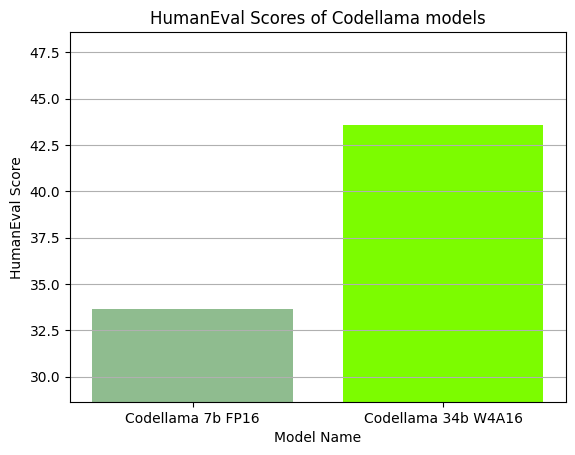

In [11]:
import matplotlib.pyplot as plt

def plot_human_eval_scores(scores):
    # Create a bar chart of the HumanEval scores
    plt.bar(scores.keys(), scores.values(), color=['darkseagreen', 'lawngreen'])
    plt.grid(True, axis='y')
    plt.title('HumanEval Scores of Codellama models')
    plt.ylim(min(scores.values()) - 5, max(scores.values()) + 5)
    plt.xlabel('Model Name')
    plt.ylabel('HumanEval Score')
    plt.show()

scores = {'Codellama 7b FP16': 33.64, 'Codellama 34b W4A16': 43.6}
plot_human_eval_scores(scores)

## The Takeaway:

The original CodeLlama 34B needed more than 63 GB of memory. We have compressed the model memory to 17 GB from 63 GB **enabling inference of CodaLlama 34B on a single 24GB GPU!**.

Moreover, this TRTLLM quantized CodeLlama 34B model's accuracy is much better than that of CodeLlama 7B (which is about 14 GB in size). Both of these models require similar resources to run. 

**Best in class models are very often achieved by optimizing a large model down to meet your requirements rather than starting with a smaller model.**

We have several other effective optimization techniques such as NAS, pruning, sparsity etc. We are releasing them as preview features for GTC'2024. Please reach out to us if you would like to learn more.

Lets stop the profiler now and check how much memory our code generation consumed.

In [12]:
torch.cuda.cudart().cudaProfilerStop()
free_memory_after = torch.cuda.mem_get_info()
print(
    f"Used GPU memory: {(free_memory_before[0] - free_memory_after[0]) / 1024 / 1024 / 1024} GB"
)

Used GPU memory: 17.736328125 GB


Sweet!

## Conclusion

We have successfully quantized CodeLlama 34B Pytorch model and built TRTLLM engine for fast and cost-effective inference. 
The quantized CodeLlama 34B is significantly better than models requiring similar compute-resources in coding capabilities.

Quantization is thus a very effective model optimization technique which compresses the model, accelerate inference while retaining most of the model quality.

This is almost a free lunch !!! &#128571; &#128571;